<a href="https://colab.research.google.com/github/yeabwang/Human-Emotions-Detection/blob/main/Human_Emotion_detection_with_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Multiply, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,DepthwiseConv2D,
                                     RandomContrast, Rescaling, Resizing, Reshape, ReLU)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [ ]:
# Load the dataset

files.upload()
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
!chmod 600 /root/.kaggle/kaggle.json

!pip install kaggle --upgrade
!pip install --upgrade pip

!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes
!unzip "human-emotions-datasethes.zip" -d "/content/dataset"

In [5]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 10,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [6]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names= CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 6799 files belonging to 3 classes.


In [7]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names= CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 2278 files belonging to 3 classes.


In [8]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.025)),
    RandomFlip(mode = "horizontal"),
    RandomContrast(factor = 0.1),
])

In [9]:
def augment_layer(image, label):
  return augment_layers(image, training=True), label

In [10]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [11]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [12]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

validation_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

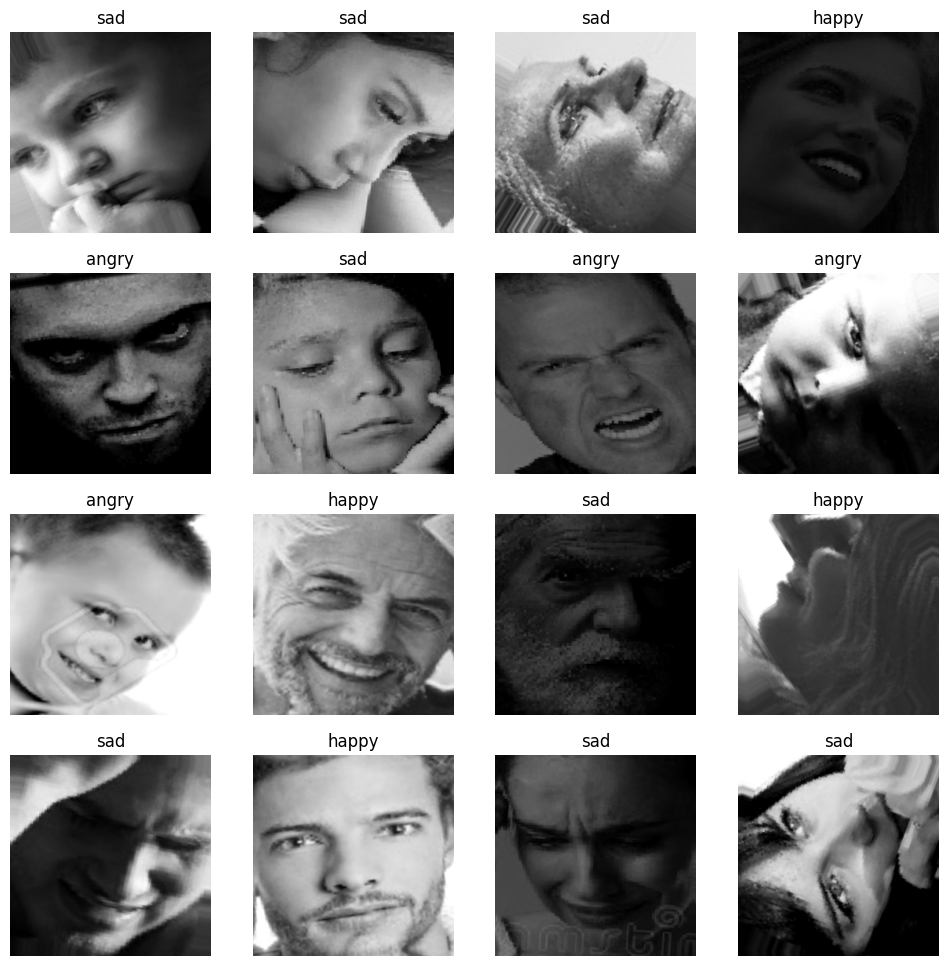

In [13]:
plt.figure(figsize=(12,12))

for sample in mixed_dataset.take(1):
    (images, labels) = sample[0]  # Extract images and labels from sample a tuple
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy() / 255.0)
        plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis=0).numpy()])
        plt.axis("off")

In [14]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/126954.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

In [15]:
patches = tf.image.extract_patches(images = tf.expand_dims(test_image, axis = 0),
                           sizes = [1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           strides = [1,CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           rates = [1,1,1,1],
                           padding= "VALID"     )

patches = tf.reshape(patches, (patches.shape[0], -1, patches.shape[-1]))
print(patches.shape)

(1, 256, 768)


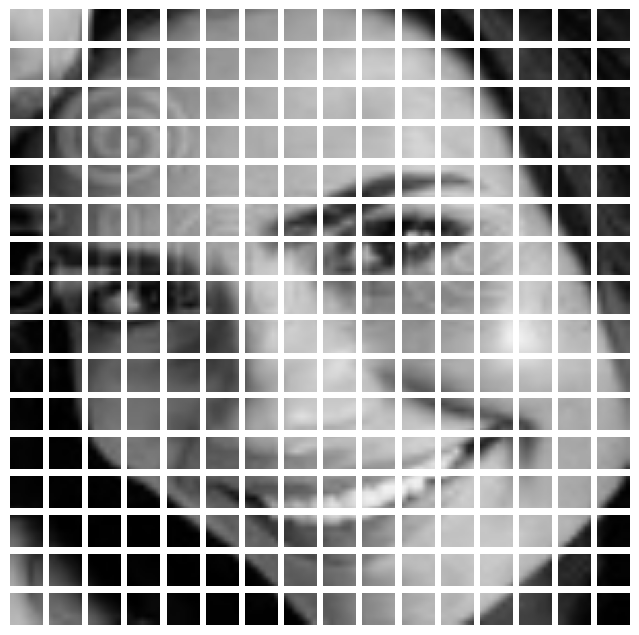

In [16]:
plt.figure(figsize=(8,8))

for i in range(patches.shape[1]):
  ax = plt.subplot(16,16, i+1)
  plt.imshow(tf.reshape(patches[0,i,:], (16,16,3)))
  plt.axis("off")

## Building ViT From scratch

In [17]:
# Patch Encoder

class PatchEncoder(Layer):
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    super(PatchEncoder, self).__init__(name = "patch_encoder")

    self.linear_projection = Dense(HIDDEN_SIZE)
    self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE)
    self.N_PATCHES = N_PATCHES

  def call(self, x):
    patches = tf.image.extract_patches(
        images = x,
        sizes = [1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        strides = [1,CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        rates = [1,1,1,1],
        padding= "VALID" )


    patches = tf.reshape(patches, (tf.shape(patches)[0], -1, patches.shape[-1]))
    embedding_input = tf.range(start = 0, limit = self.N_PATCHES, delta = 1)
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)

    return output

In [18]:
patch_enc = PatchEncoder(256, 768)
patch_enc(tf.zeros([32,256,256,3]))

<tf.Tensor: shape=(32, 256, 768), dtype=float32, numpy=
array([[[-0.02808071, -0.00124893,  0.04493718, ..., -0.00968332,
          0.01771328, -0.02777705],
        [-0.00293022, -0.0024308 ,  0.01534725, ..., -0.03363141,
         -0.03981315,  0.02268258],
        [ 0.00407735, -0.02006813, -0.02787745, ...,  0.03664631,
         -0.01786145, -0.03498515],
        ...,
        [ 0.02170915, -0.03445592,  0.0049854 , ...,  0.00765424,
          0.01759462,  0.01168252],
        [-0.01687123,  0.0191811 , -0.04999744, ...,  0.00450296,
         -0.01590877, -0.04946482],
        [-0.00966636,  0.00331308,  0.0094648 , ..., -0.01096343,
         -0.04278276, -0.01189329]],

       [[-0.02808071, -0.00124893,  0.04493718, ..., -0.00968332,
          0.01771328, -0.02777705],
        [-0.00293022, -0.0024308 ,  0.01534725, ..., -0.03363141,
         -0.03981315,  0.02268258],
        [ 0.00407735, -0.02006813, -0.02787745, ...,  0.03664631,
         -0.01786145, -0.03498515],
        ...

In [19]:
# Transformer Encoder

class TransformerEncoder(Layer):
  def __init__(self, N_HEADS, HIDDEN_SIZE):
    super(TransformerEncoder, self).__init__(name = "transformer_encoder")

    self.layer_norm_1 = LayerNormalization()
    self.layer_norm_2 = LayerNormalization()

    self.multihead_attention = MultiHeadAttention(N_HEADS, HIDDEN_SIZE)

    self.dense_1 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    self.dense_2 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)

  def call(self, input):

    x_1 = self.layer_norm_1(input)
    x_1 = self.multihead_attention(x_1, x_1)

    x_1 = Add()([x_1, input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)

    output = Add()([output, x_1])

    return output

In [20]:
trans_enc = TransformerEncoder(8, 768)
trans_enc(tf.zeros([1,256, 768]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [21]:
class ViT(Model):
  def __init__(self, N_PATCHES, N_LAYERS, N_HEADS, HIDDEN_SIZE, N_DENSE_UNITS):
    super(ViT, self).__init__(name="vision_transformer_model")

    self.N_LAYERS = N_LAYERS

    self.patch_enc = PatchEncoder(N_PATCHES, HIDDEN_SIZE)

    self.trans_enc_layers = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]

    self.dense_1 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_2 = Dense(N_DENSE_UNITS, tf.nn.gelu)

    self.dense_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")

  def call(self, input, training=True):
    x = self.patch_enc(input)

    for encoder_layer in self.trans_enc_layers:
      x = encoder_layer(x)

    x = Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)

    output = self.dense_3(x)

    return output


In [22]:
vit = ViT (
    N_PATCHES = 256,
    N_LAYERS = 2,
    N_HEADS = 4,
    HIDDEN_SIZE = 768,
    N_DENSE_UNITS = 128
)

vit(tf.zeros([32,256,256,3]))

vit.summary()

Model: "vision_transformer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ patch_encoder (PatchEncoder)         │ ?                           │         787,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ ?                           │      10,631,424 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ ?                           │      10,631,424 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (32, 128)                   │      25,165,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (32, 128)                   │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (32, 3)                     │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,232,899 (180.18 MB)

 Trainable params: 47,232,899 (180.18 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name="accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [24]:
vit.compile(optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
                    loss = loss_function,
                    metrics = metrics)

In [25]:
history = vit.fit(
    mixed_dataset.map(cutmix),
    validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1
)

Epoch 1/10
  8/213 ━━━━━━━━━━━━━━━━━━━━ 1:40:06 29s/step - accuracy: 0.3061 - loss: 10227.0430 - top_k_accuracy: 0.8089

KeyboardInterrupt: 